In [50]:
import numpy as np 
import pandas as pd
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVC


import matplotlib.pyplot as plt
import seaborn as sns 

import json

In [19]:
from lead_scoring_marieme_alessio.config import config 
from lead_scoring_marieme_alessio.domain.pipeline_transformer import pipeline_transformer
from lead_scoring_marieme_alessio.infrastructure.clean_data_transformer import CleanDataTransformer

In [20]:
full_pipeline = pipeline_transformer()

In [21]:
path = "../data/data.csv"
clean_data= CleanDataTransformer(path)
df_test = clean_data.load_cleaned_data()
y = df_test['TARGET']
X = df_test.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 42)

In [22]:
data_transform_train = full_pipeline.fit_transform(X_train, y_train)
data_transform_test = full_pipeline.transform(X_test)

In [47]:
parameters_svm = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'gamma':('scale', 'auto'),
    'kernel': ('linear','rbf', 'poly')
}

parameters_log_reg = {
    'penalty': ('l1','l2'), 
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

parameters_rand_for = {
    'n_estimators': [10, 50,100], 
    'criterion': ['entropy', 'gini'], 
    'max_depth': [2, 3, 5, 10], 
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1,5,8] 
}

parameters_gb = {
    'loss': ['deviance', 'exponential'],
    'learning_rate' : [0.1, 10, 100], 
    'n_estimators' : [10, 50,100],
    'subsample' : [0.2, 0.5, 0.9],
    
}

In [48]:
class Algorithm:
    best_score = 0
    best_params = 0
    
    def __init__(self, name, parameters, estimator):
        self.name = name
        self.parameters = parameters
        self.estimator = estimator

In [51]:
svm = Algorithm('svm',parameters_svm, SVC(probability=True))
random_forest = Algorithm('random_forest', parameters_rand_for, RandomForestClassifier())
reg_log = Algorithm('reg_log', parameters_log_reg, LogisticRegression())
grad_boost = Algorithm('grad_boost', parameters_gb, GradientBoostingClassifier())

algorithms =[svm, random_forest,reg_log, grad_boost]

In [52]:
def tune_parameters(algorithms):
    for i in range(len(algorithms)):
        print('    %s' % algorithms[i].name)
        estimator = algorithms[i].estimator
        print(estimator)
        parameters = algorithms[i].parameters
        print(parameters)
        clf = GridSearchCV(estimator, parameters, cv=5, n_jobs=3, refit = False)
        clf.fit(data_transform_train, y_train)
        algorithms[i].best_score = clf.best_score_
        algorithms[i].best_params = clf.best_params_

In [53]:
grid_score = tune_parameters(algorithms)

    svm
SVC(probability=True)
{'C': [0.01, 0.1, 1, 10, 100], 'gamma': ('scale', 'auto'), 'kernel': ('linear', 'rbf', 'poly')}
    random_forest
RandomForestClassifier()
{'n_estimators': [10, 50, 100], 'criterion': ['entropy', 'gini'], 'max_depth': [2, 3, 5, 10], 'min_samples_split': [2, 3, 5], 'min_samples_leaf': [1, 5, 8]}
    reg_log
LogisticRegression()
{'penalty': ('l1', 'l2'), 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    grad_boost
GradientBoostingClassifier()
{'loss': ['deviance', 'exponential'], 'learning_rate': [0.1, 10, 100], 'n_estimators': [10, 50, 100], 'subsample': [0.2, 0.5, 0.9]}


svm  :  0.9397610954646985 {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'} 

SVC(probability=True)
random_forest  :  0.9337778456045912 {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50} 

RandomForestClassifier()
reg_log  :  0.9301072434412243 {'C': 1, 'penalty': 'l2'} 

LogisticRegression()
grad_boost  :  0.9382652367541169 {'learning_rate': 0.1, 'loss': 'deviance', 'n_estimators': 100, 'subsample': 0.9} 

GradientBoostingClassifier()


/Users/alexei/lead-scoring-alessio-marieme/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


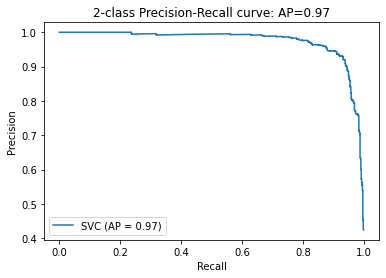

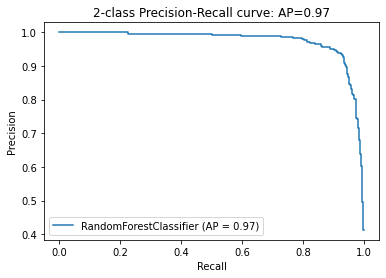

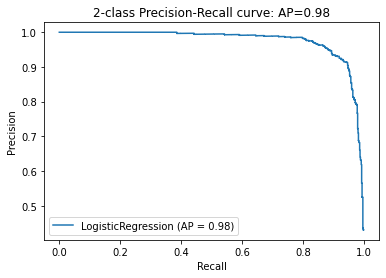

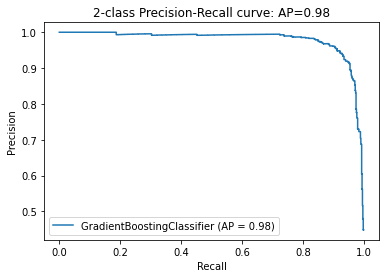

In [54]:
for i in range(len(algorithms)):
    print(algorithms[i].name, ' : ' ,algorithms[i].best_score, algorithms[i].best_params, '\n')
    
    print(algorithms[i].estimator)
    
    algorithms[i].estimator.fit(data_transform_train, y_train)
    disp = plot_precision_recall_curve(algorithms[i].estimator, data_transform_test, y_test)
    y_score = algorithms[i].estimator.predict_proba(data_transform_test)[:, 1]
    average_precision = average_precision_score(y_test, y_score)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                       'AP={0:0.2f}'.format(average_precision))

In [46]:
param_dict = dict()

for i in range(len(algorithms)):
    param_dict[algorithms[i].name] = algorithms[i].best_params

with open('best_params.json', 'w') as fp:
    json.dump(param_dict, fp)

In [19]:
parameters = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  
              'gamma':('scale', 'auto'),
              'kernel': ('linear','rbf', 'poly')}

grid = GridSearchCV(SVC(), param_grid=parameters, cv=5)
grid.fit(data_transform_train, y_train)

KeyboardInterrupt: 

In [ ]:
print("score = %3.2f" %(grid.score(data_transform_test, y_test)))
print("best parameters from train data: ", grid.best_params_)
print("best_score : ", grid.best_score_)